<a href="https://colab.research.google.com/github/LeonardoSer/Univ/blob/main/NetFlow/jupyter/Airline%20scheduling%20v1.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


## Airline scheduling

**Definition** _Airline scheduling problem_
* Given a set $\cal F$ of $n$ flights and a _flights schedule_ $\cal S$, i.e., origin $o_i$, destination $d_i$, departure $s_i$ and arrival time $a_i$ of each flight in $F$
* **Find** the minimum number of aircrafts needed to realize the schedule

**Observation**
$|\cal S|$ aircrafts is always a feasible (trivial) solution

### Example

Flight  | Origin | Destination | Departure | Arrival
--------|--------|-------------|-----------|--------
  1     | Roma   | Milano      | 6:00 a.m.   | 7:00 a.m.
  2     | Venezia| Palermo     | 7:00 a.m.  | 8:35 a.m.
  3     | Milano | Napoli      |  8:00 a.m.  | 9:15 a.m.
4       |Venezia | Catania     |  9:30 a.m. | 11:15 p.m.  
5       | Catania| Firenze     |  1:15 p.m.  | 3:00 p.m.
6       | Torino | Bari        |  5:00 p.m.  | 6:30 p.m.

The sequence of flights $1 \rightarrow 3 \rightarrow 5$ can be realized with the same aircraft. In fact, between 
arrival time of flight $1$ and departure time of flight $3$ there is enough slack for aircraft maintaince. Then, 
from Napoli airport the aircraft can flight to Catania on time for the flight $5$


### The graph model

Define a graph $G$ with the following structure:

Each flight  $i$ is represented by a pair of nodes $u_i, v_i$ and an arc directed from $u_i$ to $v_i$ with capacity $1$ and minimum flow requirement $1$


In [ ]:
flights = [1,2,3,4,5,6]

m = 3

G = nx.DiGraph()

G.add_nodes_from (['u'+str(i) for i in flights])
G.add_nodes_from (['v'+str(i) for i in flights])

for i in flights:
    G.add_edge ('u'+str(i), 'v'+str(i), lb=1, ub=1)

An arc from node $v_h$ and node $u_k$ with capacity $1$ is added to $G$ if  an aircraft can perform flight $k$ after flight $h$

**In our example:**

1. An aircraft performing flight $1$ may perform flight $3$, flights $5$ and $6$
2. An aircraft performing  flight $2$ may perform flights $5$ and $6$
3. An aircraft performing  flight $3$ may perform flights $5$ and $6$
4. An aircraft performing  flight $4$ may perform flight $6$

In [ ]:
# 1
G.add_edge ('v1','u3', lb=0, ub=1)
G.add_edge ('v1','u5', lb=0, ub=1)
G.add_edge ('v1','u6', lb=0, ub=1)

#2 
G.add_edge ('v2','u5', lb=0, ub=1)
G.add_edge ('v2','u6', lb=0, ub=1)

#3
G.add_edge ('v3','u5', lb=0, ub=1)
G.add_edge ('v3','u6', lb=0, ub=1)

#4
G.add_edge ('v4','u6', lb=0, ub=1)



Nodes $s$ and $t$ are added to G. $s$ is connected to all nodes $u$ with an arc of capacity 1.
All $v$ nodes are connected to $t$ with an arc of capacity 1

In [ ]:
G.add_node('s')
G.add_node('t')

for i in flights:
    G.add_edge ('s','u'+str(i), lb= 0, ub=1)
    G.add_edge ('v'+str(i), 't', lb= 0, ub=1)

Add an arc with capacity $m$ and flow requirement $m$ from $t$ to $s$

In [ ]:
G.add_edge('t','s', lb=m,ub=m)

In [ ]:
count = 0
offsetcol = 140

lenghtcol = offsetcol * float(len(flights))

for i in flights:
    G.nodes['u'+str(i)]['pos'] = "%f,%f"%(150, offsetcol * count)
    G.nodes['v'+str(i)]['pos'] = "%f,%f"%(450, offsetcol * count)
    count += 1
    
G.nodes['s']['pos'] = "%f,%f"%(0.0, lenghtcol / 2.0)
G.nodes['t']['pos'] = "%f,%f"%(600, lenghtcol /2.0)

for i in G.edges():
    if i[0][0] != 'u':
        G[i[0]][i[1]]['xlabel'] = '[%d,%d]'%(G[i[0]][i[1]]['lb'],G[i[0]][i[1]]['ub']) 
    else:
        G[i[0]][i[1]]['taillabel'] = '[%d,%d]'%(G[i[0]][i[1]]['lb'],G[i[0]][i[1]]['ub'])

### Notice

If you experience problems with next 2 cell, you can remove them

In [ ]:
D = nx.nx_agraph.to_agraph(G)
D.node_attr.update (fontsize='12', width=0.4, shape='circle')
D.edge_attr.update(fontsize='10', arrowhead='vee', penwidth=0.2)
D.graph_attr.update(splines='true')
D.draw ('img.svg', prog='neato', args='-n2')

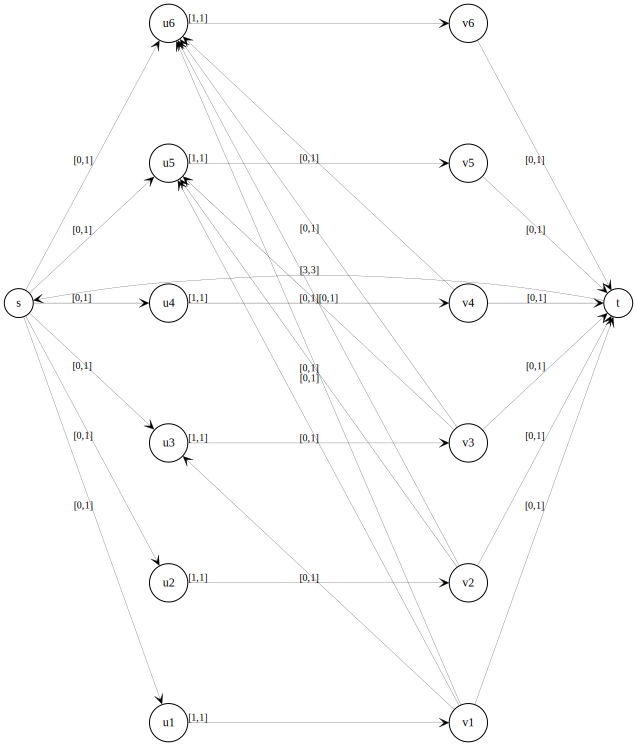

In [ ]:
from IPython.display import SVG

SVG('img.svg')

### Feasibility check

If a feasible flow exists in $G$ **then** the schedule can be realized with $m$ aircraft

### The Algorithm

**Step 1.** Generate a copy $H$ of the graph $G$

**Remember** The ``copy()`` method  makes a complete copy of the graph including all of the node or edge attributes.

In [ ]:
H = G.copy()

**Step 2.** Capacity scaling: capacity of each arc of $H$ is scaled  to $u_{ij} - l_{ij}$ 

In [ ]:
for i,j in H.edges():
    H[i][j]['capacity'] =  G[i][j]['ub'] -  G[i][j]['lb']

**Remark** Already exixst an arc $(t,s)$ with capacity $u_{ts} = m$

**Step 3.** Two extra nodes $s_1$ and $t_1$ are added to $H$


In [ ]:
H.add_node('s1')
H.add_node('t1')

**Step 4.** For each node, the flow unbalance is evaluated

**Remark** Flow unbalance is stored in a dictionary and is evaluated on graph $G$. By constructions, the sum of flow unbalance is equal to 0

In [ ]:
unbalance = {}

for i in G.nodes():
        auxunb = 0
        for h,k in G.in_edges(i):
            auxunb += G[h][k]['lb']
        
        for h,k in G.out_edges(i):
            auxunb -= G[h][k]['lb']
        
        unbalance[i] = auxunb
        
print(unbalance)
print('Sum of node unbalances:', sum(unbalance.values()))

{'u1': -1, 'u2': -1, 'u3': -1, 'u4': -1, 'u5': -1, 'u6': -1, 'v1': 1, 'v2': 1, 'v3': 1, 'v4': 1, 'v5': 1, 'v6': 1, 's': 3, 't': -3}
Sum of node unbalances: 0


**Step 5.** Two set of arcs are added to $H$:
1. Arcs $(s_1, i)$ if flow unbalance of $i>0$
2. Arcs $(i, t_1)$ if flow unbalance of $i<0$

In [ ]:
for i in unbalance:

    if unbalance[i] > 0:
        H.add_edge ('s1',i,capacity = unbalance[i])
    if unbalance[i] < 0:
        H.add_edge (i,'t1',capacity =- unbalance[i])
        

**Step 6.** Check if a valid circulation exists


In [ ]:
value, flow = nx.maximum_flow(H,'s1','t1', 'capacity')

In [ ]:
flow

{'u1': {'v1': 0, 't1': 1},
 'u2': {'v2': 0, 't1': 1},
 'u3': {'v3': 0, 't1': 1},
 'u4': {'v4': 0, 't1': 1},
 'u5': {'v5': 0, 't1': 1},
 'u6': {'v6': 0, 't1': 1},
 'v1': {'u3': 1, 'u5': 0, 'u6': 0, 't': 0},
 'v2': {'u5': 0, 'u6': 0, 't': 1},
 'v3': {'u5': 1, 'u6': 0, 't': 0},
 'v4': {'u6': 1, 't': 0},
 'v5': {'t': 1},
 'v6': {'t': 1},
 's': {'u1': 1, 'u2': 1, 'u3': 0, 'u4': 1, 'u5': 0, 'u6': 0},
 't': {'s': 0, 't1': 3},
 's1': {'v1': 1, 'v2': 1, 'v3': 1, 'v4': 1, 'v5': 1, 'v6': 1, 's': 3},
 't1': {}}

In [ ]:
valid_circulation = True

for i in H.out_edges('s1'):
    print ("Flow and capacity of arc (%s,%s):" % (i[0],i[1]), H[i[0]][i[1]]['capacity'], flow[i[0]][i[1]])
    if H[i[0]][i[1]]['capacity'] != flow[i[0]][i[1]]:
        print 
        print ("\x1b[1;31mValid circulation not found\x1b[0m")
        valid_circulation = False
        break
   

Flow and capacity of arc (s1,v1): 1 1
Flow and capacity of arc (s1,v2): 1 1
Flow and capacity of arc (s1,v3): 1 1
Flow and capacity of arc (s1,v4): 1 1
Flow and capacity of arc (s1,v5): 1 1
Flow and capacity of arc (s1,v6): 1 1
Flow and capacity of arc (s1,s): 3 3


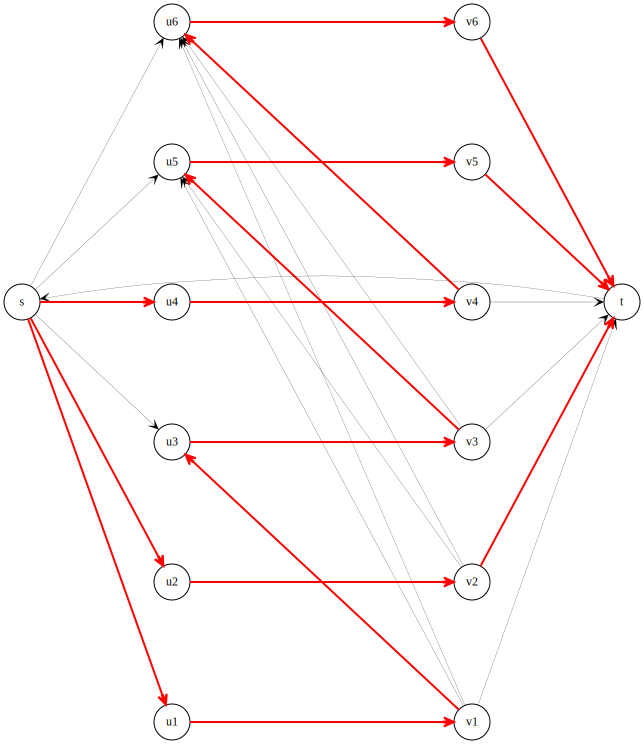

In [ ]:
for i in G.edges ():
    G[i[0]][i[1]]['xlabel'] = ''
    G[i[0]][i[1]]['taillabel'] = ''
    if flow[i[0]][i[1]] > 0 or G[i[0]][i[1]]['lb'] == 1:
            G[i[0]][i[1]]['color'] = 'red'
            G[i[0]][i[1]]['penwidth'] = '2'
    else:
        G[i[0]][i[1]]['penwidth'] = '0.2'

d = nx.nx_agraph.to_agraph(G)
d.graph_attr.update(splines='true')
d.node_attr.update (fontsize='12', shape='circle')
d.edge_attr.update(fontsize='10', arrowhead='vee')

d.draw ('img.svg', prog='neato', args='-n2')

SVG(filename='img.svg')

